In [80]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_folder
from quantum_kernel.code.kernel_measures import kernel_geometry
from quantum_kernel.code.utils import compute_additional_fields

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()

In [3]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
dataset_name='plasticc'
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/"+dataset_name,'Sparse_IQPm',False),
    ("/mnt/c/Users/lslat/Data/QK_project/results/hproj_Sparse_IQP/"+dataset_name,'Sparse_IQPm',True),

]

for folder, kernel_name,projected in folders:
    if dataset_name in dfs:
        temp = aggregate_folder(folder, dataset_name, kernel_name=kernel_name,projected=projected)[
            dataset_name]
        dfs[dataset_name] = pd.concat([dfs[dataset_name], temp])
    else:
        dfs[dataset_name] = aggregate_folder(folder, dataset_name, kernel_name=kernel_name,projected=projected)[dataset_name]

save_folder='/mnt/c/Users/lslat/Data/QK_project/figs/'

For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/hproj_Sparse_IQP/plasticc, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/hproj_Sparse_IQP/plasticc/aggregated.p


In [4]:
df = dfs[dataset_name]
iqpm_df = df[(df['kernel_name'] == 'Sparse_IQPm') & (df['dataset_dim'] == 18) & (df['projected']!='huang_proj') & (df['log_int_scaling_factor']==0.0) & (df['density']==17)]
proj_iqpm_df = df[(df['kernel_name'] == 'Sparse_IQPm') & (df['dataset_dim'] == 18) & (df['projected']=='huang_proj') & (df['log_int_scaling_factor']==0.0)]

In [5]:
proj_iqpm_df['qkern_matrix_train']=proj_iqpm_df.apply(lambda x: np.exp(-x['proj_gamma']*x['qkern_matrix_train']),axis=1)

/tmp/ipykernel_28468/487915379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_iqpm_df['qkern_matrix_train']=proj_iqpm_df.apply(lambda x: np.exp(-x['proj_gamma']*x['qkern_matrix_train']),axis=1)


In [6]:
df1 = iqpm_df[['log_scaling_factor', 'qkern_matrix_train']]
df2 = proj_iqpm_df[['log_scaling_factor', 'qkern_matrix_train']]
# compute the metric matrix and the list of sorted hyperparameters
h1s, h2s, metric_matrix = kernel_geometry.compute_metric_matrix(df1, df2, metric='geometric_difference')
# compute the reverse
rh1s, rh2s, rmetric_matrix = kernel_geometry.compute_metric_matrix(df2, df1, metric='geometric_difference')

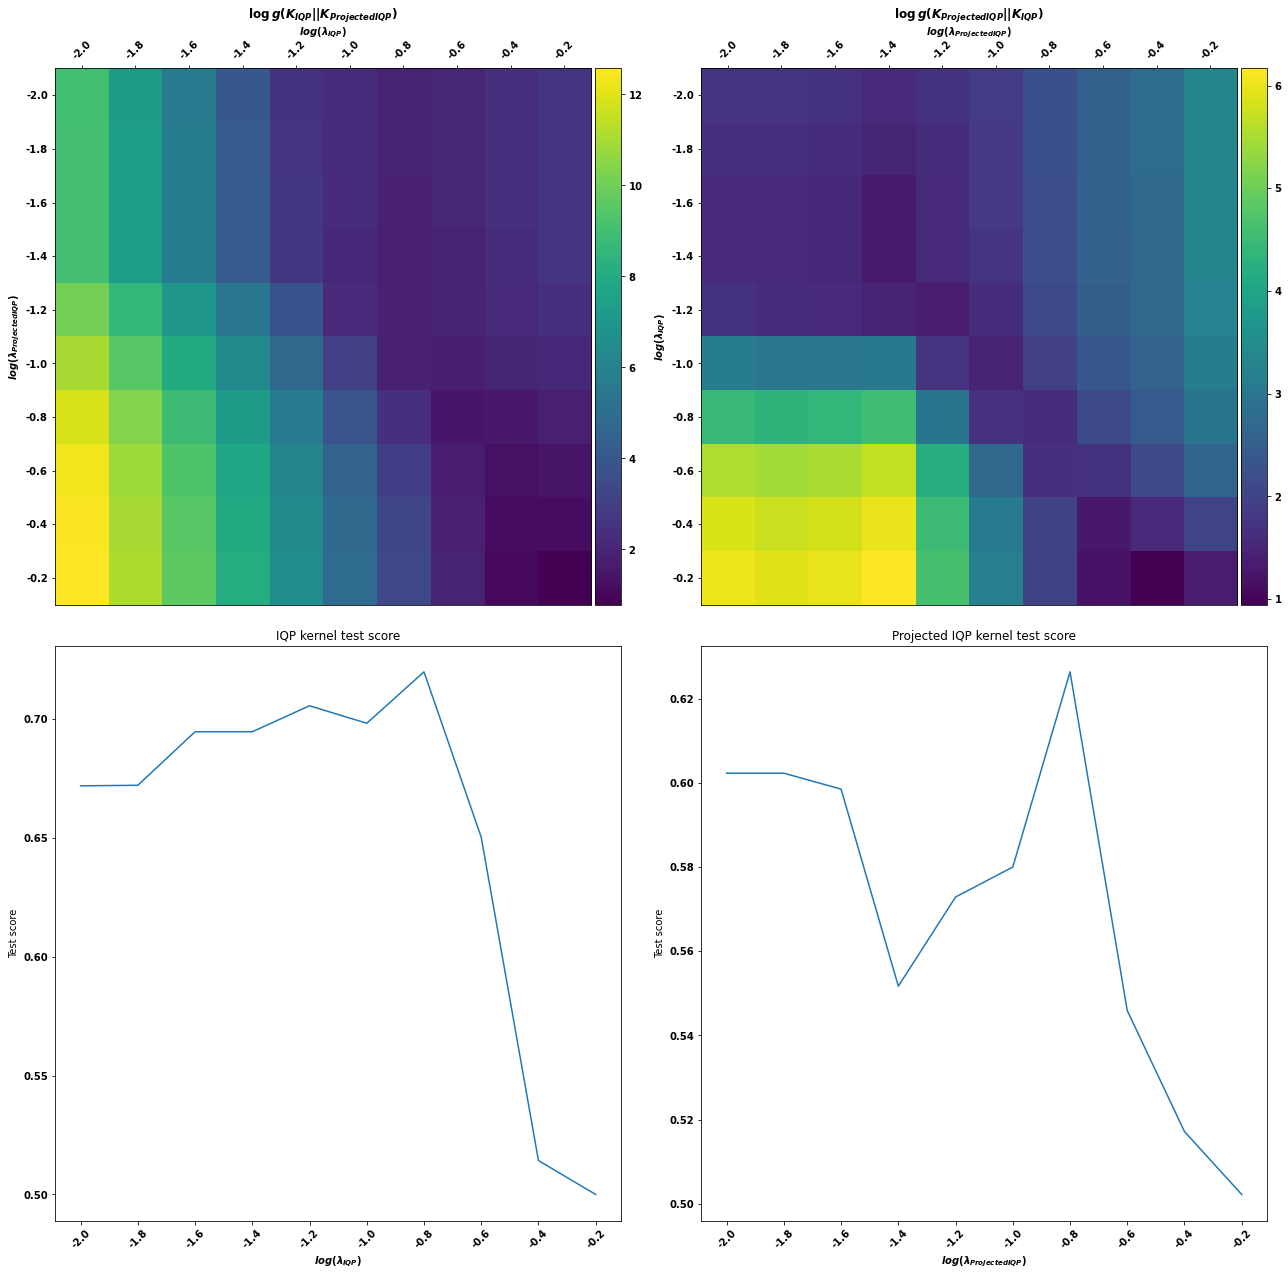

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
# Plot the geometric difference matrix
ax = axs[0][0]
img = ax.imshow(np.log(metric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{IQP})$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(h2s.shape[0]), minor=False)
ax.set_yticklabels(h2s)
ax.set_ylabel(r'$log(\lambda_{Projected IQP})$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$\log{g(K_{IQP}||K_{Projected IQP})}$')
# Now plot the reverse geometric difference matrix
ax = axs[0][1]
img = ax.imshow(np.log(rmetric_matrix))

ax.xaxis.tick_top()
ax.set_xticks(np.arange(rh1s.shape[0]), minor=False)
ax.set_xticklabels(rh1s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{Projected IQP})$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(rh2s.shape[0]), minor=False)
ax.set_yticklabels(rh2s)
ax.set_ylabel(r'$log(\lambda_{IQP})$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)
ax.set_title(r'$\log{g(K_{Projected IQP}||K_{IQP})}$')
# Plot the test score as a function of gamma for the RBF kernel.
ax = axs[1][0]
x = h1s
y = np.array([iqpm_df['test_score'].loc[iqpm_df['log_scaling_factor'] == h1].values[0] for h1 in h1s])
img = ax.plot(y)

ax.set_xticks(np.arange(h1s.shape[0]), minor=False)
ax.set_xticklabels(h1s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{IQP})$')

ax.set_ylabel('Test score')

ax.set_title('IQP kernel test score')
# Plot the test score as a function of gamma for the Laplacian Kernel.
ax = axs[1][1]
x = h2s
y = np.array([proj_iqpm_df['test_score'].loc[proj_iqpm_df['log_scaling_factor']== h2].values[0] for h2 in h2s])
img = ax.plot(y)

ax.set_xticks(np.arange(h2s.shape[0]), minor=False)
ax.set_xticklabels(h2s, rotation=45)
ax.set_xlabel(r'$log(\lambda_{Projected IQP})$')

ax.set_ylabel('Test score')

ax.set_title('Projected IQP kernel test score')

####
# plt.subplots_adjust(hspace=-0.6,wspace=0.4)
fig.tight_layout()
fig.savefig(f'{save_folder}{dataset_name}_geometric_difference_IQP_proj_IQP.pdf')

Now view the 'shape' of the projected kernel. Here I have computed a kernel where the x_vectors are random vectors with norms given by flat_norms and y_vectors = np.zeros. Gives a rough idea of the shape of the kernel by plotting kernel value vs. flat norm.

In [65]:
proj_shape_file="/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_18_huang_proj_scales_0.15848931924611134_1.0_density_17_shape_test.p"
res = pickle.load(open(proj_shape_file,'rb'))
res.update(vars(res['args']))
        
df = pd.DataFrame([res], columns=res.keys())

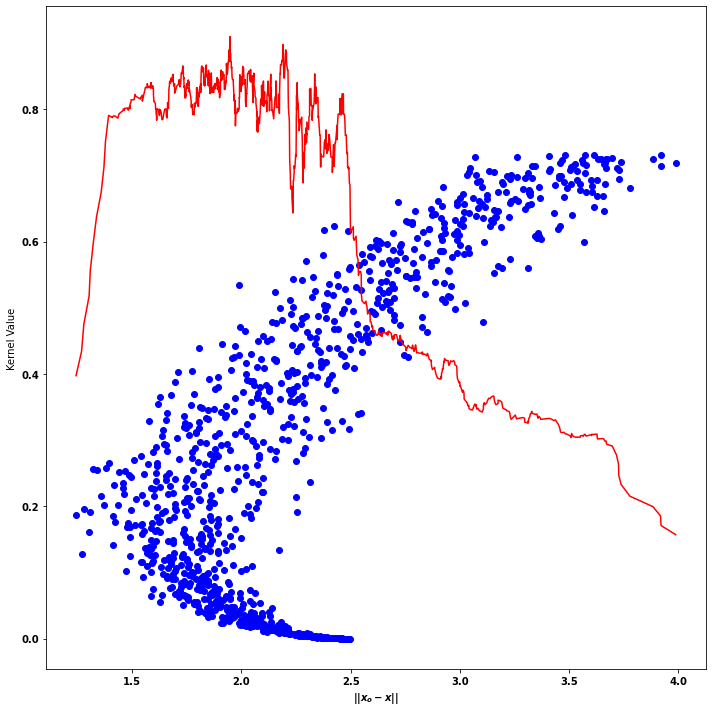

In [66]:
fig, axs = plt.subplots(1, figsize=(10, 10))
# Plot the geometric difference matrix
ax = axs
x=df.norm_diffs.values[0]
y=np.exp(-1*df.qkern_matrix_train.values[0].ravel())
points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

ax.scatter(points.T[0],points.T[1],color='blue')
moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
ax.plot(points.T[0],moving_average,color='red')

ax.set_xlabel(r'$\||x_o-x\||$')
ax.set_ylabel('Kernel Value')

fig.tight_layout()
fig.savefig(f'{save_folder}huang_proj_IQP_shape_test.pdf')

In [53]:
proj_shape_file="/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_18_single_proj_scales_0.15848931924611134_1.0_density_17_shape_test.p"
res = pickle.load(open(proj_shape_file,'rb'))
res.update(vars(res['args']))
        
df = pd.DataFrame([res], columns=res.keys())

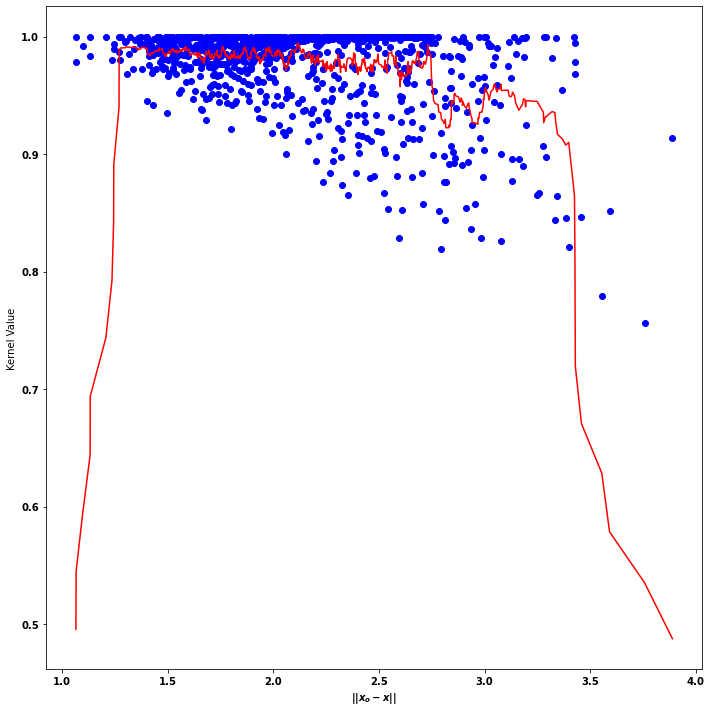

In [58]:
fig, axs = plt.subplots(1, figsize=(10, 10))
# Plot the geometric difference matrix
ax = axs
x=df.norm_diffs.values[0]
y=np.exp(-1*df.qkern_matrix_train.values[0].ravel())
points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

ax.scatter(points.T[0],points.T[1],color='blue')
moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
ax.plot(points.T[0],moving_average,color='red')

ax.set_xlabel(r'$\||x_o-x\||$')
ax.set_ylabel('Kernel Value')

fig.tight_layout()
fig.savefig(f'{save_folder}single_proj_IQP_shape_test.pdf')

In [61]:
proj_shape_file="/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_18_scales_0.15848931924611134_1.0_density_17_shape_test.p"
res = pickle.load(open(proj_shape_file,'rb'))
res.update(vars(res['args']))
        
df = pd.DataFrame([res], columns=res.keys())

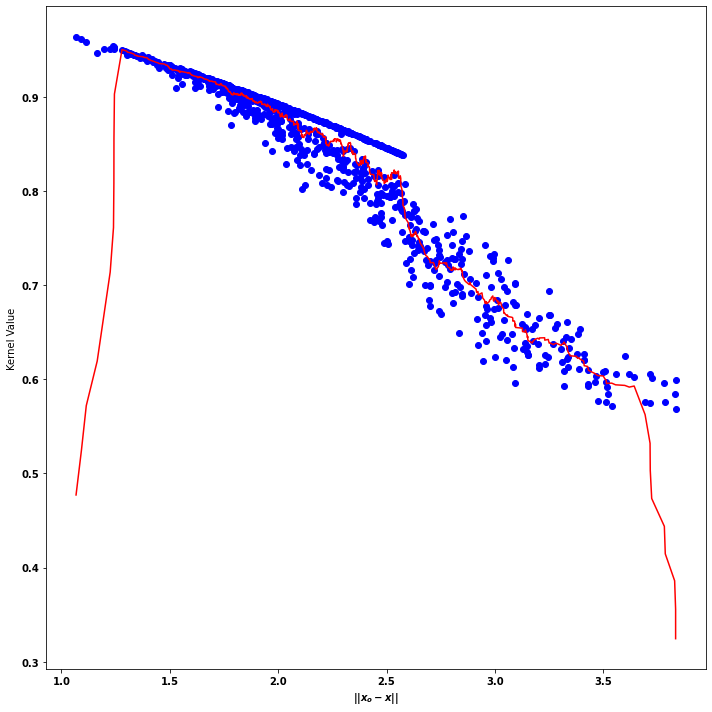

In [62]:
fig, axs = plt.subplots(1, figsize=(10, 10))
# Plot the geometric difference matrix
ax = axs
x=df.norm_diffs.values[0]
y=df.qkern_matrix_train.values[0].ravel()
points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

ax.scatter(points.T[0],points.T[1],color='blue')
moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
ax.plot(points.T[0],moving_average,color='red')

ax.set_xlabel(r'$\||x_o-x\||$')
ax.set_ylabel('Kernel Value')

fig.tight_layout()
fig.savefig(f'{save_folder}IQP_shape_test.pdf')

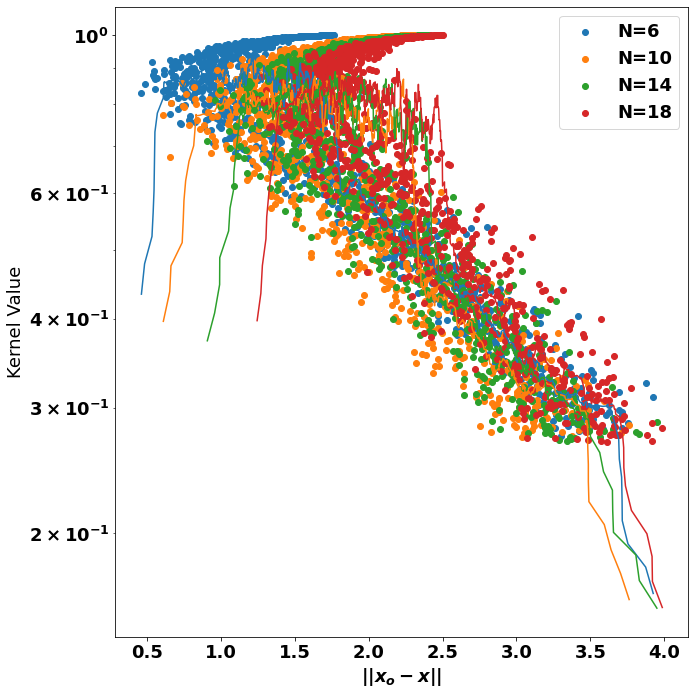

In [118]:
fig, axs = plt.subplots(1, figsize=(10, 10))

for N in [6,10,14,18]:
    proj_shape_file=f"/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_{N}_huang_proj_scales_0.15848931924611134_1.0_density_17_shape_test.p"
    res = pickle.load(open(proj_shape_file,'rb'))
    res.update(vars(res['args']))
    df = pd.DataFrame([res], columns=res.keys())

    # Plot the geometric difference matrix
    ax = axs
    x=df.norm_diffs.values[0]
    y=np.exp(-1*df.qkern_matrix_train.values[0].ravel())
    points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

    ax.scatter(points.T[0],points.T[1],label='N='+str(N))
    moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
    ax.plot(points.T[0],moving_average)

    ax.set_xlabel(r'$\||x_o-x\||$')
    ax.set_ylabel('Kernel Value')
    ax.set_yscale('log')

fig.tight_layout()
plt.legend()
fig.savefig(f'{save_folder}varN_huang_proj_IQP_K_shape_test.pdf')



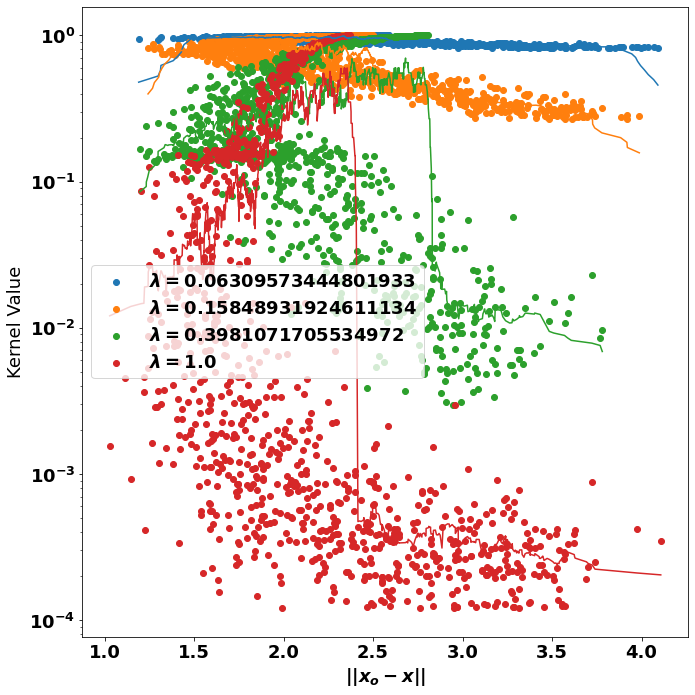

In [117]:
fig, axs = plt.subplots(1, figsize=(10, 10))

for lam in [0.06309573444801933,0.15848931924611134,0.3981071705534972,1.0]:
    proj_shape_file=f"/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_18_huang_proj_scales_{lam}_1.0_density_17_shape_test.p"
    res = pickle.load(open(proj_shape_file,'rb'))
    res.update(vars(res['args']))
    df = pd.DataFrame([res], columns=res.keys())

    # Plot the geometric difference matrix
    ax = axs
    x=df.norm_diffs.values[0]
    y=np.exp(-1*df.qkern_matrix_train.values[0].ravel())
    points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

    ax.scatter(points.T[0],points.T[1],label='$\lambda=$'+str(lam))
    moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
    ax.plot(points.T[0],moving_average)

    ax.set_xlabel(r'$\||x_o-x\||$')
    ax.set_ylabel('Kernel Value')
    ax.set_yscale('log')

fig.tight_layout()
plt.legend()
fig.savefig(f'{save_folder}varLambda_huang_proj_IQP_K_shape_test.pdf')



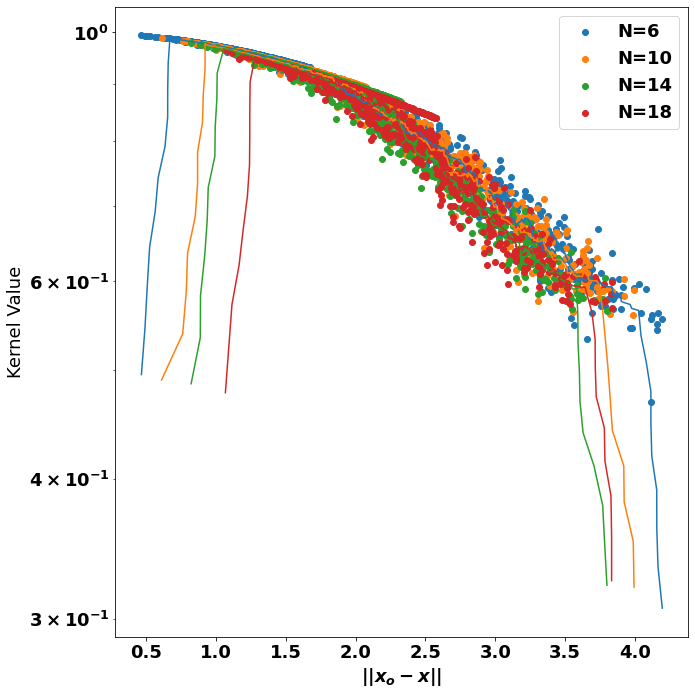

In [113]:
fig, axs = plt.subplots(1, figsize=(10, 10))

for N in [6,10,14,18]:
    proj_shape_file=f"/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_{N}_scales_0.15848931924611134_1.0_density_17_shape_test.p"
    res = pickle.load(open(proj_shape_file,'rb'))
    res.update(vars(res['args']))
    df = pd.DataFrame([res], columns=res.keys())

    # Plot the geometric difference matrix
    ax = axs
    x=df.norm_diffs.values[0]
    y=df.qkern_matrix_train.values[0].ravel()
    points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

    ax.scatter(points.T[0],points.T[1],label='N='+str(N))
    moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
    ax.plot(points.T[0],moving_average)

    ax.set_xlabel(r'$\||x_o-x\||$')
    ax.set_ylabel('Kernel Value')
    ax.set_yscale('log')

fig.tight_layout()
plt.legend()
fig.savefig(f'{save_folder}varN_IQP_K_shape_test.pdf')




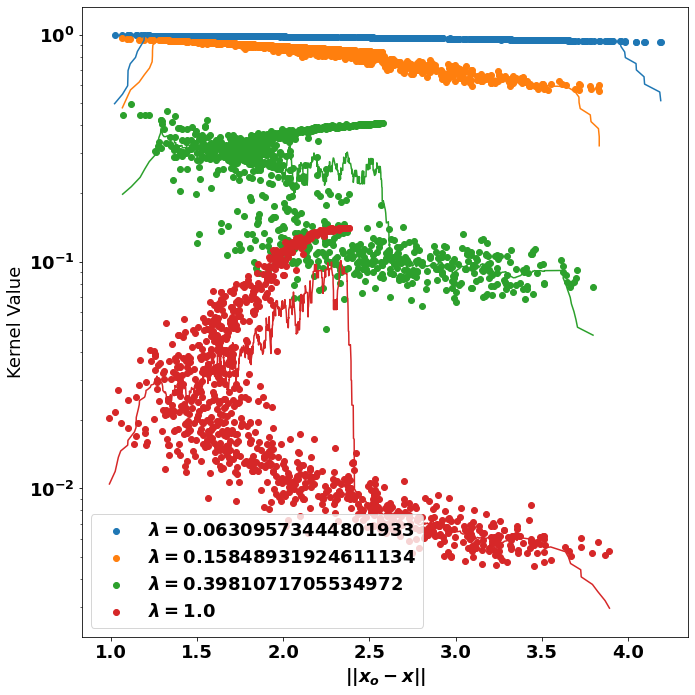

In [116]:
fig, axs = plt.subplots(1, figsize=(10, 10))

for lam in [0.06309573444801933,0.15848931924611134,0.3981071705534972,1.0]:
    proj_shape_file=f"/mnt/c/Users/lslat/Data/QK_project/results/kernel_shapes/Sparse_IQP_dim_18_scales_{lam}_1.0_density_17_shape_test.p"
    res = pickle.load(open(proj_shape_file,'rb'))
    res.update(vars(res['args']))
    df = pd.DataFrame([res], columns=res.keys())

    # Plot the geometric difference matrix
    ax = axs
    x=df.norm_diffs.values[0]
    y=df.qkern_matrix_train.values[0].ravel()
    points = np.array(sorted(zip(x,y), key = lambda x: x[0]))

    ax.scatter(points.T[0],points.T[1],label='$\lambda=$'+str(lam))
    moving_average=np.convolve(points.T[1],np.ones(20),'same')/20
    ax.plot(points.T[0],moving_average)

    ax.set_xlabel(r'$\||x_o-x\||$')
    ax.set_ylabel('Kernel Value')
    ax.set_yscale('log')

fig.tight_layout()
plt.legend()
fig.savefig(f'{save_folder}varLambda_IQP_K_shape_test.pdf')


